In [1]:
# %load_ext autoreload
# %autoreload 2

import sys
import os
from pathlib import Path

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

Internal imports   
The following cell ensures that the Python files in the `project_dir/code/` directory can be correctly imported by this notebook

In [2]:
# Add the project's `code` directory to the Python path
notebooks_dir = os.getcwd()
project_dir = os.path.dirname(notebooks_dir)
code_dir = os.path.join(project_dir, 'code')  
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

from my_utils import dict_from_disk, load_image_as_tensor


from visualisation_utils import plot_masks_grid

Device

In [3]:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
DEVICE

device(type='cuda')

Reproducibility

In [4]:
torch.manual_seed(0)
np.random.seed(0)

if DEVICE.type == 'cuda':
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Load cross-attention maps from disk

In [5]:
DATA_PATH = Path(r"C:\Users\aapolina\CODE\diffusion_segmentation\DATA\data\data\ECSSD_resized")

In [6]:
# Set the path to the directory containing the cross-attention maps
FEATURE_DIR = Path(f"{DATA_PATH}/features/cross_attn_cpu")

# Filter files in directory for the cross-attention maps
cross_attn_filenames = sorted([f for f in FEATURE_DIR.glob("*.h5") if f.stem.endswith("_cross")])

# Load the cross-attention maps
#list of 1000 samples, for each sample, first a dict with timestep keys, then for each timestep a dict with resolution keys
cross_attn_maps = [dict_from_disk(str(f)) for f in tqdm(cross_attn_filenames)] 


100%|██████████| 1000/1000 [00:26<00:00, 37.55it/s]


In [7]:
cross_attn_maps[0].keys()

dict_keys([0, 111, 222, 333, 444, 555, 666, 777, 888, 999])

In [8]:
GT_DIR = Path(f"{DATA_PATH}/gt")

# Load the ground truth masks for the cross-attention maps as (64, 64) tensors
base_names = map(lambda path: path.stem, cross_attn_filenames)
gt_paths = sorted([GT_DIR / f"{base_name.split('_')[0]}.png" for base_name in base_names])
gt_segmentations = [load_image_as_tensor(path, True) for path in gt_paths]

### Create a dataset and data loader from cross-attention maps

In [9]:
cross_attn_maps_train, cross_attn_maps_valid, gt_segmentations_train, gt_segmentations_valid = train_test_split(cross_attn_maps, gt_segmentations, test_size=0.2, random_state=0, shuffle=False)

In [10]:
from cross_attention_dataset import CrossAttentionDataset

dataset = CrossAttentionDataset(cross_attn_maps, gt_segmentations)

batch_size = 16
shuffle = True

dataset_train = CrossAttentionDataset(cross_attn_maps_train, gt_segmentations_train)
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=shuffle)

dataset_valid = CrossAttentionDataset(cross_attn_maps_valid, gt_segmentations_valid)
data_loader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=shuffle)

### Train model

In [63]:
from probing_models import LinearProbe3

model = LinearProbe3().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = torch.nn.BCELoss()

In [64]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)


91

In [65]:
def store_weights(model):
    weights = []
    [weights.extend(v) for k,v in model.state_dict().items()]
    weights = [w.detach().cpu().numpy().tolist() for w in weights]
    return weights


In [66]:
def store_weights_epoch(model):
    return {'wt': model.ts_weights.detach().cpu().numpy().tolist(), 
            #'wc':model.ch_weights.detach().cpu().numpy().tolist(), 
            'wr':model.res_weights.detach().cpu().numpy().tolist(), 
            #'ws':model.scale_weights.detach().cpu().numpy().tolist()
            }

In [67]:
def L1_penalty(model):
    L1 = 0
    for p in model.parameters():
        L1 = L1 + p.abs().sum()
    #return torch.sum(torch.abs(model.ts_weights)) + torch.sum(torch.abs(model.ch_weights)) + torch.sum(torch.abs(model.res_weights)) + torch.sum(torch.abs(model.scale_weights))
    return L1

L1_penalty(model)


lambda_L1 = 1e-3

In [68]:
def L2_penalty(model):
    L2 = 0
    for p in model.parameters():
        L2 = L2 + p.pow(2).sum()
    return L2

L2_penalty(model)

lambda_L2 = 1e-4


In [69]:
def evaluate_training(model,loader, criterion):
    loss_valid = []
    with torch.no_grad():
        
        for  cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, gt in loader:
            cross_attn_8 = cross_attn_8.squeeze().to(DEVICE)
            cross_attn_16 = cross_attn_16.squeeze().to(DEVICE)
            cross_attn_32 = cross_attn_32.squeeze().to(DEVICE)
            cross_attn_64 = cross_attn_64.squeeze().to(DEVICE)
            gt = gt.to(DEVICE)
            output = model([cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64])


            loss = criterion(output, gt)
            #loss += lambda_L1 * L1_penalty(model)
            loss_valid.append(loss.item())

    return loss_valid #np.mean(loss_valid)

In [70]:
import datetime, json
timestamp = datetime.datetime.now().strftime("%y%m%d_%H%M%S")

modelname = 'linearprobe3'
runname = f"{timestamp}"

In [71]:
losses_train = []
losses_valid = []

losses_train_all = []
losses_valid_all = []

all_weights = {}

best_valid_loss = {'epoch': None, 'loss': None, 'state_dict': None}

for epoch in range(20):
    loss_epoch_train=[]

    with tqdm(data_loader_train, desc=f"Epoch {epoch}") as tepoch:

        for cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, gt in tepoch:
            cross_attn_8 = cross_attn_8.squeeze().to(DEVICE)
            cross_attn_16 = cross_attn_16.squeeze().to(DEVICE)
            cross_attn_32 = cross_attn_32.squeeze().to(DEVICE)
            cross_attn_64 = cross_attn_64.squeeze().to(DEVICE)
            gt = gt.to(DEVICE)

            optimizer.zero_grad()

            # Forward pass
            output = model([cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64])
            loss = criterion(output, gt)

            #loss += lambda_L1 * L1_penalty(model)

            loss_epoch_train.append(loss.item())

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update the progress bar description
            tepoch.set_description(f"Epoch {epoch}")# Loss: {loss.item():.4f}")

    all_weights[epoch] = store_weights_epoch(model)
    

    loss_epoch_valid = evaluate_training(model, data_loader_valid, criterion)

    losses_train_all.append(loss_epoch_train) 
    losses_valid_all.append(loss_epoch_valid)
       
    loss_epoch_train = np.mean(loss_epoch_train)
    loss_epoch_valid = np.mean(loss_epoch_valid)

    if best_valid_loss['loss'] is None or loss_epoch_valid < best_valid_loss['loss']:
        best_valid_loss['epoch'] = epoch
        best_valid_loss['loss'] = loss_epoch_valid
        best_valid_loss['state_dict'] = model.state_dict()

    losses_train.append(loss_epoch_train)
    losses_valid.append(loss_epoch_valid)  

    print(f"Epoch {epoch} \n Train Loss: {loss_epoch_train:.4f} \n Valid Loss: {loss_epoch_valid:.4f}")
    

# after a finished run, save the weights and model
with open(f"{runname}_{modelname}_weights.json", 'w') as f:
    json.dump(all_weights, f)

torch.save(best_valid_loss['state_dict'], f"{runname}_{modelname}_epoch={best_valid_loss['epoch']:02d}_loss={best_valid_loss['loss']:.4f}.ckpt")


Epoch 0: 100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


Epoch 0 
 Train Loss: 0.5809 
 Valid Loss: 0.5524


Epoch 1: 100%|██████████| 50/50 [00:07<00:00,  6.92it/s]


Epoch 1 
 Train Loss: 0.4941 
 Valid Loss: 0.4666


Epoch 2: 100%|██████████| 50/50 [00:07<00:00,  6.87it/s]


Epoch 2 
 Train Loss: 0.4282 
 Valid Loss: 0.4429


Epoch 3: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s]


Epoch 3 
 Train Loss: 0.4034 
 Valid Loss: 0.4200


Epoch 4: 100%|██████████| 50/50 [00:06<00:00,  7.20it/s]


Epoch 4 
 Train Loss: 0.3842 
 Valid Loss: 0.4011


Epoch 5: 100%|██████████| 50/50 [00:06<00:00,  7.15it/s]


Epoch 5 
 Train Loss: 0.3687 
 Valid Loss: 0.3881


Epoch 6: 100%|██████████| 50/50 [00:07<00:00,  7.12it/s]


Epoch 6 
 Train Loss: 0.3553 
 Valid Loss: 0.3714


Epoch 7: 100%|██████████| 50/50 [00:06<00:00,  7.31it/s]


Epoch 7 
 Train Loss: 0.3423 
 Valid Loss: 0.3594


Epoch 8: 100%|██████████| 50/50 [00:06<00:00,  7.35it/s]


Epoch 8 
 Train Loss: 0.3306 
 Valid Loss: 0.3468


Epoch 9: 100%|██████████| 50/50 [00:06<00:00,  7.22it/s]


Epoch 9 
 Train Loss: 0.3193 
 Valid Loss: 0.3361


Epoch 10: 100%|██████████| 50/50 [00:06<00:00,  7.21it/s]


Epoch 10 
 Train Loss: 0.3084 
 Valid Loss: 0.3230


Epoch 11: 100%|██████████| 50/50 [00:06<00:00,  7.31it/s]


Epoch 11 
 Train Loss: 0.2990 
 Valid Loss: 0.3221


Epoch 12: 100%|██████████| 50/50 [00:06<00:00,  7.38it/s]


Epoch 12 
 Train Loss: 0.2892 
 Valid Loss: 0.3012


Epoch 13: 100%|██████████| 50/50 [00:06<00:00,  7.33it/s]


Epoch 13 
 Train Loss: 0.2811 
 Valid Loss: 0.2997


Epoch 14: 100%|██████████| 50/50 [00:06<00:00,  7.35it/s]


Epoch 14 
 Train Loss: 0.2771 
 Valid Loss: 0.2887


Epoch 15: 100%|██████████| 50/50 [00:06<00:00,  7.34it/s]


Epoch 15 
 Train Loss: 0.2682 
 Valid Loss: 0.2832


Epoch 16: 100%|██████████| 50/50 [00:06<00:00,  7.29it/s]


Epoch 16 
 Train Loss: 0.2632 
 Valid Loss: 0.2780


Epoch 17: 100%|██████████| 50/50 [00:06<00:00,  7.36it/s]


Epoch 17 
 Train Loss: 0.2580 
 Valid Loss: 0.2737


Epoch 18: 100%|██████████| 50/50 [00:06<00:00,  7.39it/s]


Epoch 18 
 Train Loss: 0.2550 
 Valid Loss: 0.2727


Epoch 19: 100%|██████████| 50/50 [00:06<00:00,  7.38it/s]


Epoch 19 
 Train Loss: 0.2509 
 Valid Loss: 0.2678


### Visualize the evolution of the weights during training

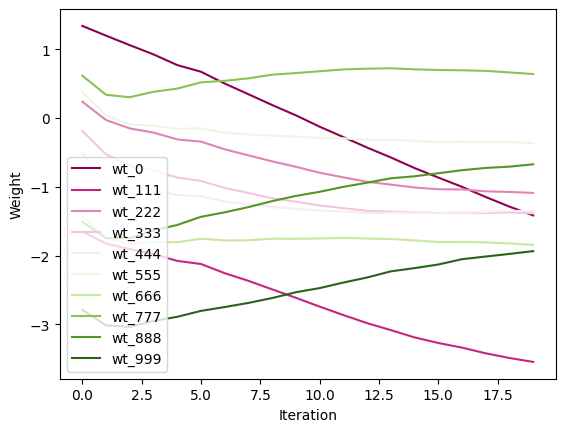

In [72]:

for w in ['wt']:#['wt', 'wc', 'wr', 'ws']:
    n = len(all_weights[0][w])
    if w=='wt':
        suffix = [0, 111, 222, 333, 444, 555, 666, 777, 888, 999]
    elif w=='wc':
        suffix = range(77)
    elif w=='wr':
        suffix = [8,16,32,64]
    elif w=='ws':
        suffix = [""]   
    assert n==len(suffix)
    colors = plt.cm.PiYG(np.linspace(0,1,n))  
                        
    for i in range(n):
        data = [all_weights[epoch][w][i] for epoch in all_weights.keys()]
        plt.plot(data, label = f"{w}_{suffix[i]}", color=colors[i])

plt.xlabel('Iteration')
plt.ylabel('Weight')
plt.legend()

# Show the plot
plt.show()

In [73]:
# import pandas as pd
# df = pd.DataFrame(data=all_weights[0])
# df.T.plot(legend=False, figsize=(20,15))

# new_weights = all_weights[0][0]
# old_weights = all_weights[0][0]

def plot_weights(old_weights, new_weights):

    # Plot the old_weights
    plt.plot(old_weights, label='Old Weights')

    # Plot the new_weights
    plt.plot(new_weights, label='New Weights')

    # Add labels and legend
    plt.xlabel('Iteration')
    plt.ylabel('Weight')
    plt.legend()

    # Show the plot
    plt.show()


### Plot Train and Validation losses

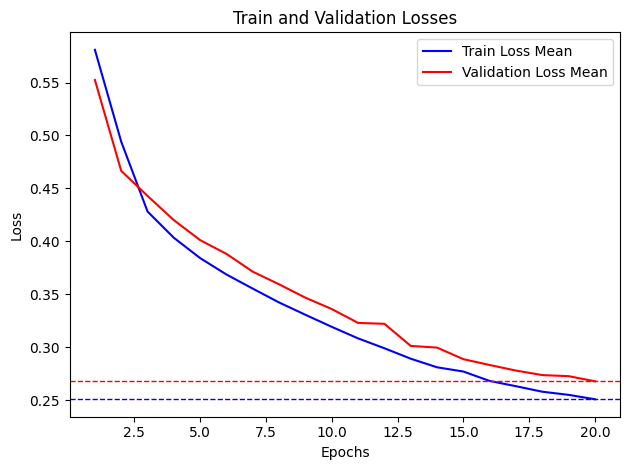

In [74]:
import matplotlib.pyplot as plt

epochs = range(1, len(losses_train) + 1)


plt.plot(epochs, losses_train, 'b', label='Train Loss Mean')
plt.plot(epochs, losses_valid, 'r', label='Validation Loss Mean')

# add min loss lines
lt_min = min(losses_train)
plt.axhline(lt_min, color='blue', linestyle='--',lw=1)
plt.annotate(text=f"{lt_min:.3f}",xy=(0,lt_min+0.001),color='blue'    )
lv_min = min(losses_valid)  
plt.axhline(lv_min, color='red', linestyle='--',lw=1)
plt.annotate(text=f"{lv_min:.3f}",xy=(0,lv_min+0.001),color='red'    )

plt.title('Train and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

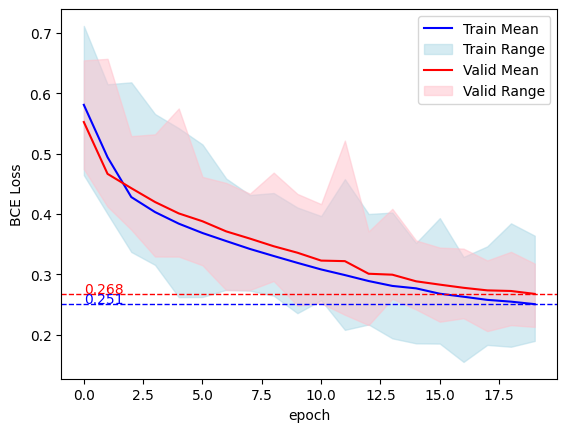

In [75]:
y_train = np.array(losses_train_all)
y_valid = np.array(losses_valid_all)

x = list(range(len(y_train)))
y_train_mean = np.mean(y_train, axis=1)
y_train_min = np.min(y_train, axis=1)
y_train_max = np.max(y_train, axis=1)
y_valid_mean = np.mean(y_valid, axis=1)
y_valid_min = np.min(y_valid, axis=1)
y_valid_max = np.max(y_valid, axis=1)

# Plot the line on the mean and shaded area of the range for training and validation losses
plt.plot(x, y_train_mean, color='blue', label='Train Mean')
plt.fill_between(x, y_train_min, y_train_max, color='lightblue', alpha=0.5, label='Train Range')

plt.plot(x, y_valid_mean, color='red', label='Valid Mean')
plt.fill_between(x, y_valid_min, y_valid_max, color='pink', alpha=0.5, label='Valid Range')


# add min loss lines
lt_min = min(losses_train)
plt.axhline(lt_min, color='blue', linestyle='--',lw=1)
plt.annotate(text=f"{lt_min:.3f}",xy=(0,lt_min+0.001),color='blue'    )

lv_min = min(losses_valid)  
plt.axhline(lv_min, color='red', linestyle='--',lw=1)
plt.annotate(text=f"{lv_min:.3f}",xy=(0,lv_min+0.001),color='red'    )

# Add labels and legend
plt.xlabel('epoch')
plt.ylabel('BCE Loss')
plt.legend()

# Show the plot
plt.show()

# Save/Load the trained model to/from checkpoint

(saving the last state for now)

In [219]:
# modelname = 'linearprobe3'
# checkpoint_path = os.path.join(os.getcwd(), f'{timestamp}_{modelname}.ckpt')

root_path = r"C:\Users\aapolina\CODE\diffusion_segmentation\REPO\diffusion_segmentation\training\linear probe 3"
model_path = r"231231_004407_linearprobe3_epoch29_loss0.2604.ckpt"
checkpoint_path = os.path.join(root_path, model_path)   

In [220]:
# save the model
# torch.save(model.state_dict(), checkpoint_path)

In [221]:
# load model from checkpoint
from probing_models import LinearProbe3
model = LinearProbe3().to(DEVICE)
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

# Visualize the results 
### predicted mask vs. ground truth

In [222]:
def IoU(prediction, groundtruth):
    intersection = np.logical_and(groundtruth, prediction)
    union = np.logical_or(groundtruth, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def dice_coefficient(prediction, groundtruth):
    intersection = np.logical_and(groundtruth, prediction)
    dsc = (2 * np.sum(intersection)) / (np.sum(groundtruth) + np.sum(prediction))
    return dsc

def precision(prediction, groundtruth):
    intersection = np.logical_and(groundtruth, prediction)
    prec = np.sum(intersection) / np.sum(prediction)
    return prec

def recall(prediction, groundtruth):
    intersection = np.logical_and(groundtruth, prediction)
    rec = np.sum(intersection) / np.sum(groundtruth)
    return rec

def accuracy(prediction, groundtruth):
    acc = np.sum(prediction == groundtruth) / np.prod(groundtruth.shape)
    return acc

def F1_score(prediction, groundtruth):
    prec = precision(prediction, groundtruth)
    rec = recall(prediction, groundtruth)
    f1 = 2 * (prec * rec) / (prec + rec)
    return f1

def performance_metrics(prediction, groundtruth):
    iou = IoU(prediction, groundtruth)
    dsc = dice_coefficient(prediction, groundtruth)
    prec = precision(prediction, groundtruth)
    rec = recall(prediction, groundtruth)
    acc = accuracy(prediction, groundtruth)
    f1 = F1_score(prediction, groundtruth)
    return iou, dsc, prec, rec, acc, f1

def mask_pecentage(mask):
    return np.sum(mask) / np.prod(mask.shape)

def img_binary(img):
    return (img >= 0.5).float()


In [223]:
def image_overlay_error(test_img, gt_img):

    image_overlay_error = np.zeros((test_img.shape[0], test_img.shape[1], 3))

    image_overlay_error[(test_img == 1) &  (gt_img == 1)] = [1,1,1]         # correct as 1 - white
    image_overlay_error[(test_img == 0) &  (gt_img == 0)] = [0,0,0]         # correct as 0 - black 
    image_overlay_error[(test_img == 1) &  (gt_img == 0)] = [1, 0.65, 0]     # false positive (mislabelled background as foreground) - orange
    image_overlay_error[(test_img == 0) &  (gt_img == 1)] = [0, 0.55,0.7]    # false negative (mislabelled foreground as background) - blue

    return image_overlay_error


def plot_img_output_gt(indices):

    fig, axs = plt.subplots(3, len(indices), figsize=(15, 5))

    for i, idx in enumerate(indices):
        img = load_image_as_tensor(gt_paths[idx].parent.parent / "img" / (gt_paths[idx].stem + ".jpg"))
        gt = load_image_as_tensor(gt_paths[idx], True)

        with torch.no_grad():
            cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, gt = dataset[idx]
            output = model(cross_attn_8.to(DEVICE), cross_attn_16.to(DEVICE),cross_attn_32.to(DEVICE), cross_attn_64.to(DEVICE))
            
            loss = criterion(output, gt.to(DEVICE)).cpu()
            output = output.squeeze().detach().cpu()

        axs[0, i].imshow(img.permute(1, 2, 0))
        axs[0, i].set_title(f"Image {idx}")

        axs[1, i].imshow(output)
        axs[1, i].set_title(f"Output {idx}: {loss:.4f}")

        axs[2, i].imshow(gt)
        axs[2, i].set_title(f"Ground Truth {idx}: {loss:.4f}")

    plt.tight_layout()
    plt.show()



def plot_segmentation_results(idx, img, output, gt, loss, save=False):

    fig, axs = plt.subplots(1, 5, figsize=(15, 5))

    gt = img_binary(gt)
    output_binary = img_binary(output)

    diff = image_overlay_error(output_binary, gt)
    iou_score = IoU(output_binary.numpy(),gt.numpy())

    axs[0].imshow(img.permute(1, 2, 0))
    axs[1].imshow(output, cmap='bone')
    axs[2].imshow(output_binary, cmap='bone')
    axs[3].imshow(diff )
    axs[4].imshow(gt, cmap='gray')

    axs[0].set_title(f'Image {idx}')
    axs[1].set_title(f'Output {loss:.3f}')
    axs[2].set_title('Output Binary')
    axs[3].set_title(f'Diff. IoU={iou_score:.3f}')
    axs[4].set_title('Ground Truth')

    plt.tight_layout()

    if save:
        path = r"C:\Users\aapolina\CODE\diffusion_segmentation\output\231221_cross_attn_upsampled\diff"
        filename = f'img_{idx}.png'
        plt.savefig(os.path.join(path, filename))   

In [224]:
def results_one_sample(idx):

    img = load_image_as_tensor(gt_paths[idx].parent.parent / "img" / (gt_paths[idx].stem + ".jpg"))
    gt = load_image_as_tensor(gt_paths[idx], True)

    with torch.no_grad():
        cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, _ = dataset[idx]
        cross_attn_8 = cross_attn_8.squeeze().to(DEVICE).unsqueeze(0)
        cross_attn_16 = cross_attn_16.squeeze().to(DEVICE).unsqueeze(0)
        cross_attn_32 = cross_attn_32.squeeze().to(DEVICE).unsqueeze(0)
        cross_attn_64 = cross_attn_64.squeeze().to(DEVICE).unsqueeze(0)
        gt = gt.to(DEVICE)
        output = model([cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64]).squeeze(0)
        loss = criterion(output, gt)
    
    output = output.cpu()
    gt = gt.cpu()
    loss = loss.item()

    return img, output, gt, loss



In [225]:
model.to(DEVICE)
DEVICE

device(type='cuda')

(0.9509394572025052,
 1.0092801312147262,
 0.9748528624933119,
 1.0462280391859988,
 0.92578125,
 1.0092801312147262,
 0.09666457027196884,
 0.4251694679260254)

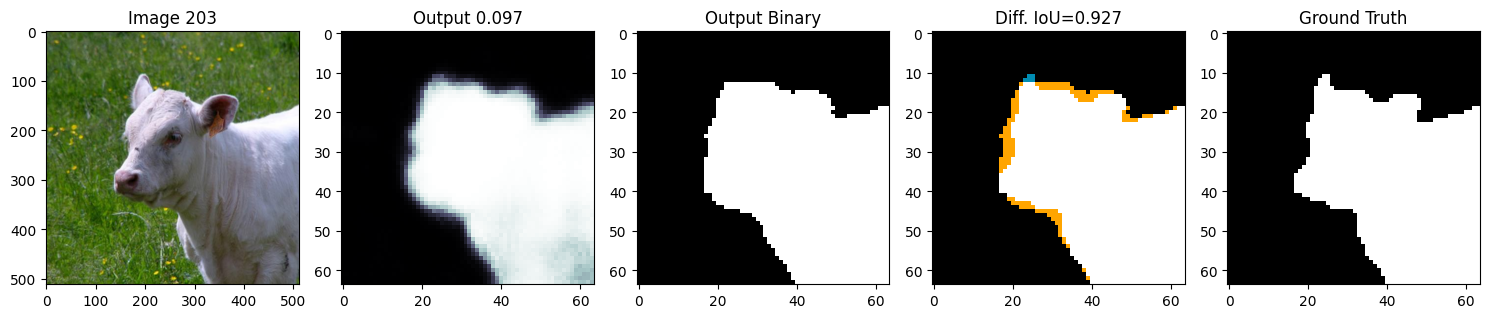

In [238]:
idx = 203
img, output, gt, loss = results_one_sample(idx)
plot_segmentation_results(idx, img, output, gt, loss, False)

output_np = img_binary(output).numpy()
gt_np = gt.numpy() 
iou, dsc, prec, rec, acc, f1 = performance_metrics(output_np, gt_np) 
iou, dsc, prec, rec, acc, f1, loss, mask_pecentage(gt_np)


# Calculate scores/metrics
for the whole dataset

In [240]:
all_results={'iou':[], 'dice':[], 'loss':[], 'mask_perc':[]}

for idx in range(1000):
    img, output, gt, loss = results_one_sample(idx)
    output_np = img_binary(output).numpy()
    gt_np = gt.numpy() 
    all_results['iou'].append(IoU(output_np, gt_np))
    all_results['dice'].append(dice_coefficient(output_np, gt_np))  
    all_results['loss'].append(loss)
    all_results['mask_perc'].append(mask_pecentage(gt_np))


In [241]:
def plot_scatter_results(all_results, sx = "mask_perc", sy = "iou"):
    labels = {'iou': "IoU", 'dice': "Dice", 'loss': "Loss", 'mask_perc': "Mask Percentage"}

    
    # Scatter plot
    x = all_results[sx]
    y = all_results[sy]
    plt.scatter(x,y, color='red', marker='o', s=1)

    # Add dashed lines for mean x and mean y
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    plt.axvline(mean_x,linestyle='--', lw=1,  color='red')
    plt.axhline(mean_y, linestyle='--', lw=1, color='red')

    plt.annotate(text=f"Mean: {mean_x:.2f}", xy=(mean_x, 0), color='red')
    plt.annotate(text=f"Mean: {mean_y:.2f}", xy=(0, mean_y), color='red')


    #add trendline to plot
    # z = np.polyfit(x,y,deg=1)
    # p = np.poly1d(z)
    # plt.plot(x, p(x), color='red', linestyle=':', lw=0.5)


    # Set labels and title
    plt.xlabel(labels[sx])
    plt.ylabel(labels[sy])
    plt.title(f"All samples results ({labels[sx]} vs {labels[sy]})")

    # Show the plot
    plt.tight_layout()
    plt.show()


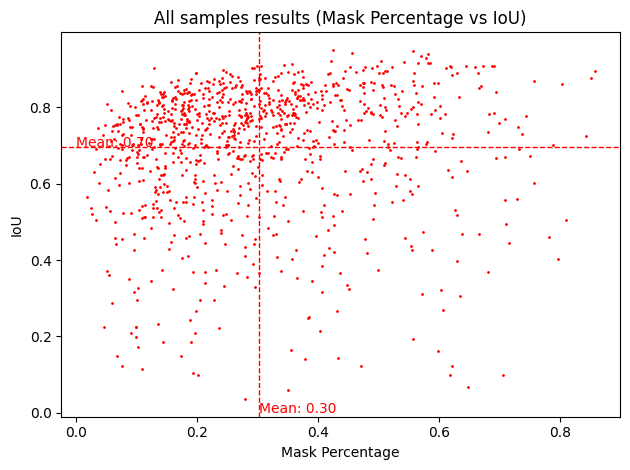

In [242]:
plot_scatter_results(all_results, sx = "mask_perc", sy = "iou")


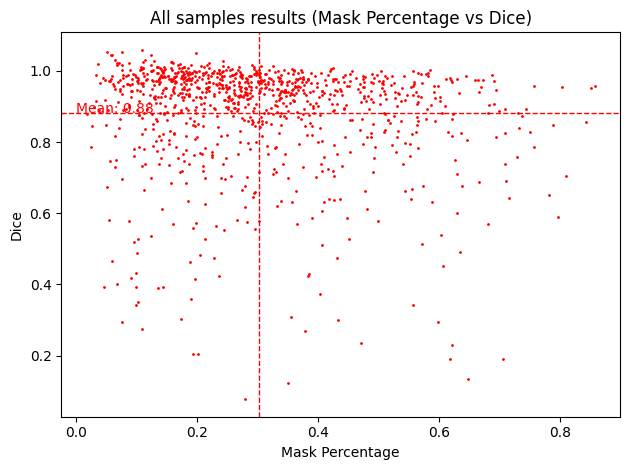

In [243]:
plot_scatter_results(all_results, sx = "mask_perc", sy = "dice")

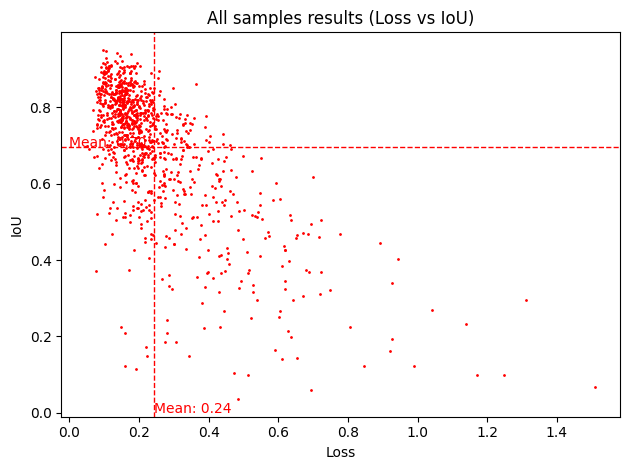

In [244]:
plot_scatter_results(all_results, sx = "loss", sy = "iou")

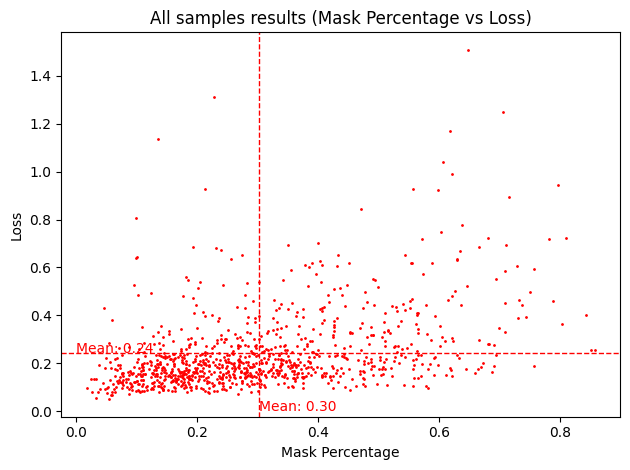

In [245]:
plot_scatter_results(all_results, sx = "mask_perc", sy = "loss")

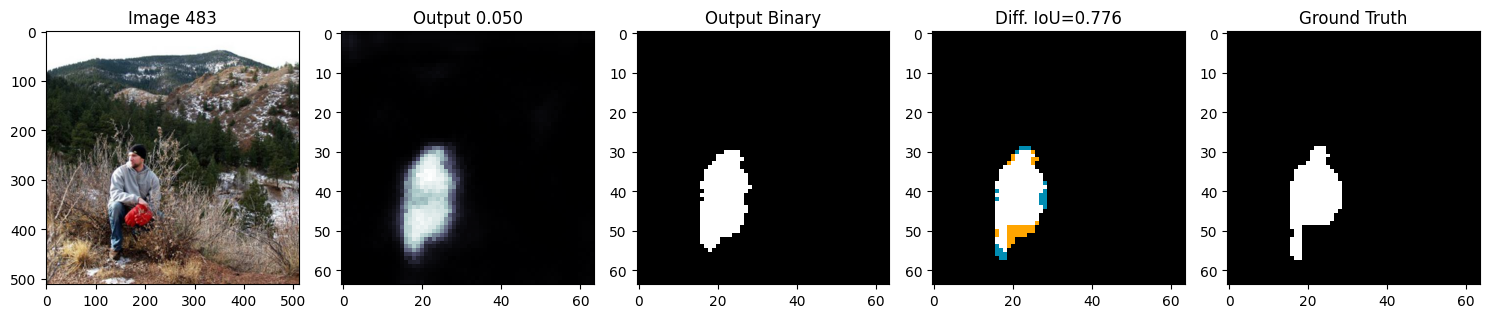

In [246]:
best_loss = min(all_results['loss'])
idx = all_results['loss'].index(best_loss)

plot_segmentation_results( idx, *results_one_sample(idx), False)

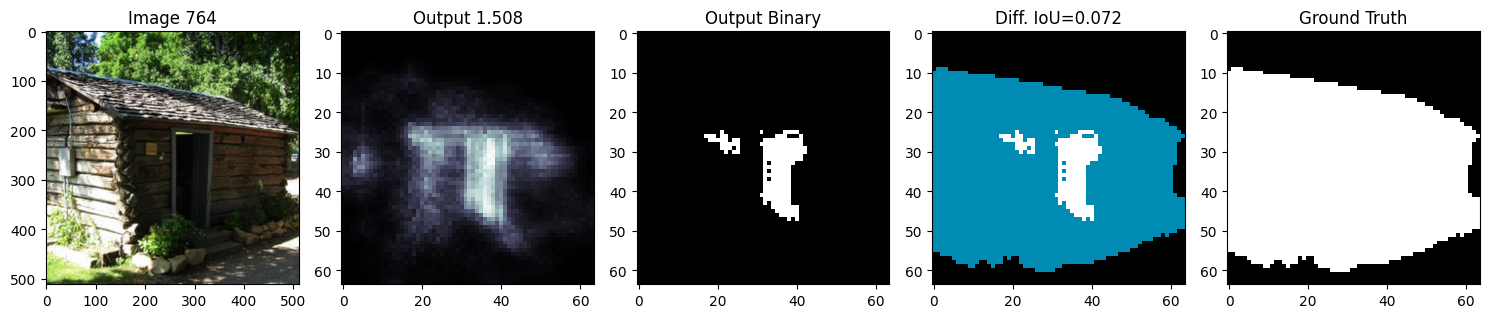

In [247]:
worst_loss = max(all_results['loss'])
idx = all_results['loss'].index(worst_loss)

plot_segmentation_results( idx, *results_one_sample(idx), False)

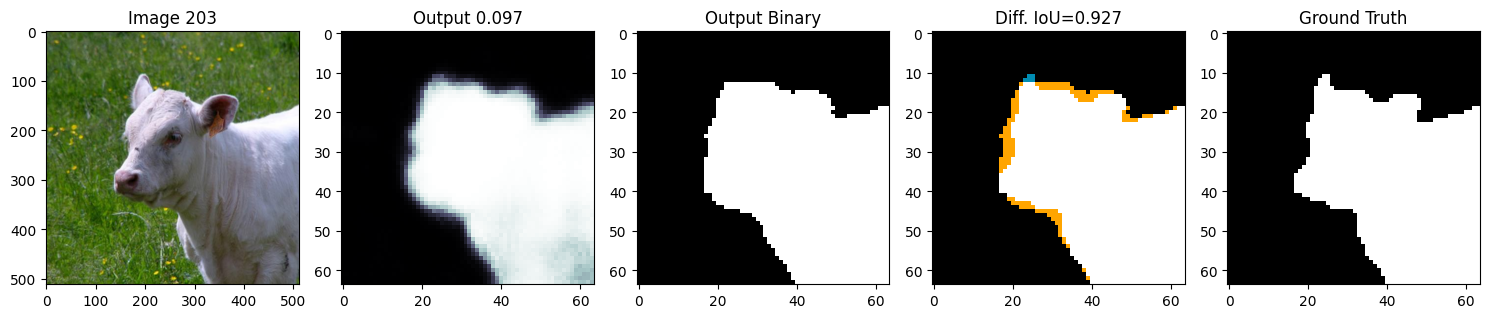

In [248]:
best_iou = max(all_results['iou'])
idx = all_results['iou'].index(best_iou)
plot_segmentation_results( idx, *results_one_sample(idx), False)


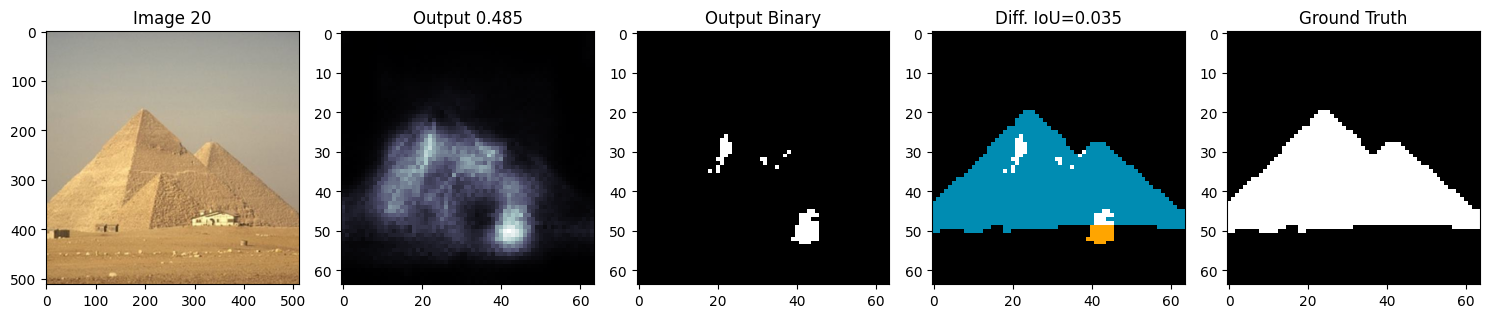

In [249]:
worst_iou = min(all_results['iou'])
idx = all_results['iou'].index(worst_iou)
plot_segmentation_results( idx, *results_one_sample(idx), False)